In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
import matplotlib.pyplot as plt
import random
import time
from sklearn.preprocessing import minmax_scale
warnings.filterwarnings('ignore')

In [2]:
mnist_train = pd.read_csv('../mnist_kmnist_train.csv',header=None)
mnist_train_label = pd.read_csv('../mnist_kmnist_train_label.csv',header=None)
mnist_train_label = np.array([x[0] for x in np.array(mnist_train_label)])
fmnist_train = pd.read_csv('../fmnist_kmnist_train.csv',header=None)
fmnist_train_label = pd.read_csv('../fmnist_kmnist_train_label.csv',header=None)
fmnist_train_label = np.array([x[0] for x in np.array(fmnist_train_label)])

In [3]:
mnist_test = pd.read_csv('../mnist_kmnist_test.csv',header=None)
mnist_test_label = pd.read_csv('../mnist_kmnist_test_label.csv',header=None)
mnist_test_label = np.array([x[0] for x in np.array(mnist_test_label)])
fmnist_test = pd.read_csv('../fmnist_kmnist_test.csv',header=None)
fmnist_test_label = pd.read_csv('../fmnist_kmnist_test_label.csv',header=None)
fmnist_test_label = np.array([x[0] for x in np.array(fmnist_test_label)])

In [4]:
train_data = pd.concat([mnist_train, fmnist_train],axis=0,ignore_index=True)
test_data = pd.concat([mnist_test, fmnist_test],axis=0,ignore_index=True)
train_label = np.concatenate([mnist_train_label, fmnist_train_label+10])
test_label = np.concatenate([mnist_test_label, fmnist_test_label+10])

In [5]:
train_data = pd.DataFrame(minmax_scale(train_data,axis=1))
test_data = pd.DataFrame(minmax_scale(test_data,axis=1))

In [13]:
def generate_transformation_matrix(n_kc,n_orn,n_response,seed):
    R = np.zeros((n_kc, n_orn))
    for i in range(n_kc):
        random.seed(i+seed)
        np.random.seed(i+seed)
        R[i,random.sample(list(range(n_orn)), n_response)] = 1
    return R


def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.matmul(R,p)
    KC[KC<=thresh] = 0
    threshold = np.quantile(KC,0.95)
    KC[KC<threshold] = 0
    #KC[KC>0] = 1
    KC = KC/np.max(KC)
    return KC

In [6]:
def split_data(data, labels, split):
    from collections import Counter
    distinct_labels = list(Counter(labels).keys())
    n_labels = len(distinct_labels)
    n_split = int(n_labels/split)
    trans = data.T
    trans.columns = labels
    datasets = {}
    datalabels = {}
    for i in range(n_split):
        cond1 = trans.columns.values >= i*split
        cond2 = trans.columns.values < (i+1)*split
        out = trans.iloc[:,cond1&cond2]
        out_label = out.columns.values
        datasets[i] = out.T
        datalabels[i] = out_label
    return (datasets, datalabels)

In [96]:
def train(data, label, lr, n_class, shift):
    from collections import Counter
    weights = np.zeros([n_class,n_kc])#*10.0
    kcs = get_KC(data,R,thresh)
    distinct_label = np.sort(list(Counter(label).keys()))
    if len(distinct_label) != n_class:
        raise ValueError('Number of classes to be trained does not match!!!')
    for i in range(n_class):
        sum_kc = np.sum(kcs[np.array(label==distinct_label[i])],axis=0)
        weights[distinct_label[i]-shift] += lr*sum_kc
        #weights[weights<0] = 0
        weights[weights>1] = 1
    return weights

In [250]:
def accu(weights, data, label):
    #kcs = np.array([get_KC(np.array(data.iloc[i,:]),R,thresh) for i in range(data.shape[0])])
    kcs = get_KC(data,R,thresh)
    result = np.matmul(weights, kcs.T)
    pred = np.argmax(result, axis=0)
    return np.sum(pred==label)/len(label)

In [233]:
def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.matmul(R,p)
    KC[KC<=thresh] = 0
    threshold = np.quantile(KC,0.95)
    KC[KC<threshold] = 0
    KC = KC/np.max(KC)
    #KC[KC>0] = 1
    return KC

In [247]:
def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    temp = np.dot(R,p.T)
    KC = np.zeros(temp.shape)
    top = np.argpartition(KC, -int(R.shape[0]*0.05), axis=0)[-int(R.shape[0]*0.05):,:]
    KC[top,np.arange(KC.shape[1])[None,:]] = temp[top,np.arange(KC.shape[1])[None,:]]
    #KC.T[KC.T<threshold] = 0
    #KC[KC>0] = 1
    KC = KC.T/np.max(KC.T,axis=0)
    return KC

In [387]:
def get_KC(p,R,thresh):
    '''
    odor: a vector of ORN responses for a given odor
    w: inhibitory synaptic strength from LN to PN
    R: random linear transformation matrix from PN to KC
    thresh: rectlinear threshold for KC activation
    '''
    KC = np.dot(R,p.T)
    KC2 = KC/(np.sum(KC,axis=0)+1e-4)
    KC[KC2<=(1.7/R.shape[0])] = 0
    KC = KC/(np.max(KC,axis=0)+1e-4)
    return KC.T

In [118]:
import psutil, os

In [123]:
start = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
trained_weights = train(train_datasets[0], train_labels[0], 0.01, 2, 0*2)
end = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
end - start

38.68359375

In [158]:
start = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
trained_weights = train(train_datasets[0], train_labels[0], 0.01, 2, 0*2)
end = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2
end - start

0.1875

In [161]:
start = time.time()
trained_weights = train(train_datasets[0], train_labels[0], 0.01, 2, 0*2)
end = time.time()
end - start

1.315436601638794

In [206]:
R.shape

(3200, 84)

In [253]:
start = time.time()
kcs = get_KC(train_datasets[0],R,thresh)
end = time.time()
end - start

1.8293240070343018

In [215]:
train_datasets[0]

0    0.420423
1    0.629229
1    0.120966
1    0.000000
1    0.000000
       ...   
0    0.617235
1    0.541791
1    0.649467
0    0.286713
1    0.468672
Name: 0, Length: 12665, dtype: float64

In [216]:
get_KC(np.array(train_datasets[0].iloc[0,:]),R,thresh)

array([0., 0., 0., ..., 0., 0., 0.])

In [234]:
kcs = np.array([get_KC(np.array(train_datasets[0].iloc[i,:]),R,thresh) for i in range(train_datasets[0].shape[0])])

In [390]:
temp = np.dot(R,train_datasets[0].values.T)
KC = np.zeros(temp.shape)
top = np.argpartition(KC, -int(R.shape[0]*0.05), axis=0)[-int(R.shape[0]*0.05):,:]
#KC[top,np.arange(KC.shape[1])[None,:]] = temp[top,np.arange(KC.shape[1])[None,:]]

In [259]:
KC[top,np.arange(KC.shape[1])[None,:]] = temp[top,np.arange(KC.shape[1])[None,:]]

In [262]:
KC.

(160, 12665)

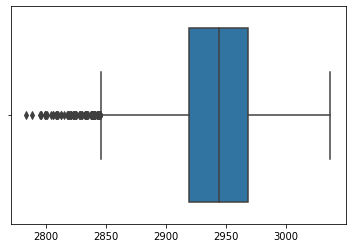

In [242]:
y = np.sum(kcs==0,axis=1)
sns.boxplot(y);

In [381]:
KC = np.dot(R,train_datasets[0].values.T)
KC2 = KC/(np.sum(KC,axis=0)+1e-4)
KC[KC2<=(1.7/R.shape[0])] = 0
KC = KC/(np.max(KC,axis=0)+1e-4)

In [382]:
x = np.max(KC,axis=0)
np.sum(x==0)

0

In [383]:
KC.shape

(3200, 12665)

In [384]:
np.max(np.sum(KC==0,axis=0))

3185

In [385]:
np.min(np.sum(KC==0,axis=0))

2931

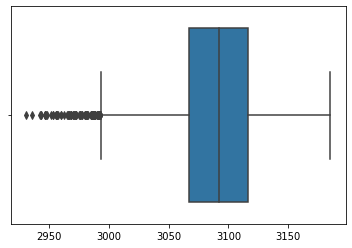

In [386]:
y = np.sum(KC==0,axis=0)
sns.boxplot(y);

In [99]:
kcs.shape 2.323518991470337

(3200, 12665)

In [9]:
train_datasets, train_labels = split_data(train_data, train_label, 2)
test_datasets, test_labels = split_data(test_data, test_label, 2)

In [25]:
train_datasets[1].T.shape

(84, 12089)

In [16]:
R = generate_transformation_matrix(n_kc,n_orn,n_response,2023)

In [24]:
R.shape

(3200, 84)

In [126]:
KC = np.dot(R,train_datasets[0].T)

In [145]:
start = time.time()
KC2 = KC/np.sum(KC,axis=0)
end = time.time()
end - start

0.24927091598510742

In [152]:
start = time.time()
KC2 = KC/(np.sum(KC,axis=0)+1e-3)
KC2[KC2<=1.6/3200] = 0
end = time.time()
end - start

0.36862993240356445

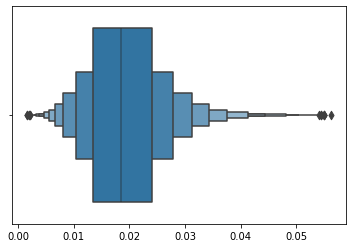

In [246]:
x = np.sum(KC2>1.8/3200,axis=0)/3200
sns.boxenplot(x);

In [87]:
start = time.time()
q = np.quantile(KC,0.95,axis=1)
end = time.time()
end - start

1.6914198398590088

In [88]:
KC.T[KC.T<q] = 0

In [90]:
KC.T/np.max(KC.T,axis=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
KC.shape

(3200, 12665)

In [40]:
int(n_kc*0.95)

3040

In [109]:
start = time.time()
top = np.argpartition(KC, -160, axis=0)[-160:,:]
end = time.time()
end - start

1.4637980461120605

In [110]:
top.shape

(160, 12665)

In [111]:
KC[top,np.arange(KC.shape[1])[None,:]] = 0

In [112]:
np.sum(KC==0,axis=0)

array([160, 161, 160, ..., 160, 160, 162])

In [106]:
KC.shape

(3200, 12665)

In [15]:
n_kc = 3200
n_orn = 84
n_response = 10
n_task = 10
thresh = 0
seeds = [1,12,21,35,78]

In [388]:
for seed in [1]:
    start = time.time()
    R = generate_transformation_matrix(n_kc,n_orn,n_response,seed)
    accuracy = np.zeros([n_task, n_task])
    trained_weights = {}
    for i in range(n_task):
        trained_weights[i] = train(train_datasets[i], train_labels[i], 0.01, 2, i*2)

        weights_to_test = np.concatenate([trained_weights[j] for j in range(i+1)])

        for j in range(i+1):
            accuracy[i,j] = accu(weights_to_test,test_datasets[j],test_labels[j])

        print('loop '+str(i+1)+' done!')
    accuracy = pd.DataFrame(accuracy)
    end = time.time()
    print(end-start)
    #accuracy.to_csv('./accuracy/FlyModel_all_result_lr0.01_randseed_'+str(seed)+'.csv',index=False,header=False)

loop 1 done!
loop 2 done!
loop 3 done!
loop 4 done!
loop 5 done!
loop 6 done!
loop 7 done!
loop 8 done!
loop 9 done!
loop 10 done!
18.400928020477295


In [371]:
accuracy

,0,1,2,3,4,5,6,7,8,9
0,0.996690,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000
1,0.973050,0.888345,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000
2,0.954137,0.796278,0.932764,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000
3,0.924350,0.783546,0.913554,0.804632,0.000000,0.0000,0.0000,0.0000,0.0000,0.000
4,0.921513,0.739961,0.878869,0.795065,0.786183,0.0000,0.0000,0.0000,0.0000,0.000
5,0.919622,0.739471,0.878335,0.793051,0.785174,0.9185,0.0000,0.0000,0.0000,0.000
6,0.917258,0.737512,0.878335,0.792044,0.785174,0.8305,0.7735,0.0000,0.0000,0.000
7,0.916312,0.735553,0.875133,0.792044,0.784165,0.8250,0.7025,0.5515,0.0000,0.000
8,0.916312,0.735553,0.874600,0.792044,0.784165,0.7995,0.6435,0.5210,0.3225,0.000
9,0.913002,0.732125,0.874600,0.790030,0.784165,0.7985,0.6400,0.5175,0.3015,0.707


In [389]:
accuracy

,0,1,2,3,4,5,6,7,8,9
0,0.997636,0.000000,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.0000,0.000
1,0.965012,0.920666,0.000000,0.000000,0.000000,0.000,0.0000,0.0000,0.0000,0.000
2,0.946572,0.842801,0.938100,0.000000,0.000000,0.000,0.0000,0.0000,0.0000,0.000
3,0.921513,0.830558,0.923159,0.849950,0.000000,0.000,0.0000,0.0000,0.0000,0.000
4,0.914421,0.790402,0.890608,0.835347,0.830055,0.000,0.0000,0.0000,0.0000,0.000
5,0.914421,0.790402,0.890608,0.834844,0.830055,0.912,0.0000,0.0000,0.0000,0.000
6,0.910165,0.790402,0.890608,0.834844,0.830055,0.798,0.7930,0.0000,0.0000,0.000
7,0.909693,0.789422,0.889541,0.834844,0.829551,0.797,0.7455,0.5725,0.0000,0.000
8,0.909693,0.789422,0.889541,0.834844,0.829047,0.775,0.6645,0.5460,0.4035,0.000
9,0.908747,0.788932,0.889541,0.834340,0.829047,0.772,0.6560,0.5455,0.3580,0.809
